In [56]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

# Create data folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')
    print("📁 Created 'data' folder\n")

# Set random seed for reproducibility
np.random.seed(42)



# Configuration
n_samples = 2000  # 2000 transactions over 6 months
start_date = datetime(2025, 7, 1)

# Define 10 realistic products across categories
products = {
    'P001': {'name': 'Wireless Headphones', 'base_price': 2499, 'cost': 1500, 'category': 'Electronics'},
    'P002': {'name': 'Gaming Mouse', 'base_price': 1299, 'cost': 780, 'category': 'Electronics'},
    'P003': {'name': 'Mechanical Keyboard', 'base_price': 3499, 'cost': 2100, 'category': 'Electronics'},
    'P004': {'name': 'Laptop Stand', 'base_price': 899, 'cost': 540, 'category': 'Accessories'},
    'P005': {'name': 'Webcam HD', 'base_price': 1999, 'cost': 1200, 'category': 'Electronics'},
    'P006': {'name': 'Phone Case', 'base_price': 499, 'cost': 200, 'category': 'Accessories'},
    'P007': {'name': 'Power Bank', 'base_price': 1499, 'cost': 900, 'category': 'Electronics'},
    'P008': {'name': 'USB Cable', 'base_price': 299, 'cost': 120, 'category': 'Accessories'},
    'P009': {'name': 'Smart Watch', 'base_price': 4999, 'cost': 3000, 'category': 'Electronics'},
    'P010': {'name': 'Bluetooth Speaker', 'base_price': 1899, 'cost': 1140, 'category': 'Electronics'}
}

# Festival dates in India (2025)
festivals = [
    (datetime(2025, 8, 15), datetime(2025, 8, 16)),   # Independence Day
    (datetime(2025, 10, 2), datetime(2025, 10, 3)),   # Gandhi Jayanti
    (datetime(2025, 10, 20), datetime(2025, 10, 24)), # Diwali
    (datetime(2025, 11, 1), datetime(2025, 11, 1)),   # Diwali extended sales
    (datetime(2025, 12, 25), datetime(2025, 12, 26))  # Christmas
]

def is_festival_period(date):
    """Check if date falls in festival period"""
    for start, end in festivals:
        if start <= date <= end:
            return 1
    return 0

# Generate data
data = []

for _ in range(n_samples):
    # Random date in last 6 months
    days_offset = np.random.randint(0, 180)
    trans_date = start_date + timedelta(days=days_offset)
    
    # Random product
    product_id = np.random.choice(list(products.keys()))
    product_info = products[product_id]
    
    base_price = product_info['base_price']
    cost = product_info['cost']
    
    # Current price with realistic variation (±10%)
    price_variation = np.random.uniform(-0.10, 0.10)
    current_price = int(base_price * (1 + price_variation))
    
    # Competitor price (usually within ±15% of our price)
    competitor_variation = np.random.uniform(-0.15, 0.15)
    competitor_price = int(current_price * (1 + competitor_variation))
    
    # Time features
    day_of_week = trans_date.weekday()  # 0=Monday, 6=Sunday
    month = trans_date.month
    is_weekend = 1 if day_of_week >= 5 else 0
    is_festival = is_festival_period(trans_date)
    
    # Inventory level (will be encoded later as 0/1/2)
    inventory_level = np.random.choice(['Low', 'Medium', 'High'], p=[0.2, 0.5, 0.3])
    
    # Customer segment (optional feature - can remove if model gets complex)
    customer_segment = np.random.choice(['Budget', 'Standard', 'Premium'], p=[0.3, 0.5, 0.2])
    
    # ========== REALISTIC DEMAND CALCULATION ==========
    # Base demand depends on product category
    if product_info['category'] == 'Electronics':
        base_demand = np.random.randint(20, 60)
    else:
        base_demand = np.random.randint(30, 80)
    
    # Price competitiveness effect (major factor)
    price_diff = competitor_price - current_price
    if price_diff > 0:  # We're cheaper
        price_effect = price_diff * 0.08
    else:  # We're expensive
        price_effect = price_diff * 0.12
    
    # Festival boost
    festival_effect = np.random.randint(15, 30) if is_festival else 0
    
    # Weekend boost
    weekend_effect = np.random.randint(5, 12) if is_weekend else 0
    
    # Month seasonality
    if month in [11, 12]:
        seasonal_effect = 15
    elif month in [1, 2]:
        seasonal_effect = -10
    else:
        seasonal_effect = 0
    
    # Customer segment effect
    segment_effects = {'Budget': -5, 'Standard': 0, 'Premium': 8}
    segment_effect = segment_effects[customer_segment]
    
    # Inventory effect
    inventory_effects = {'Low': 5, 'Medium': 0, 'High': -3}
    inventory_effect = inventory_effects[inventory_level]
    
    # Random noise
    noise = np.random.randint(-8, 8)
    
    # Final demand (can't be negative)
    demand = max(0, int(base_demand + price_effect + festival_effect + 
                       weekend_effect + seasonal_effect + segment_effect + 
                       inventory_effect + noise))
    
    # ========== CALCULATE METRICS (for evaluation only, NOT for model input) ==========
    revenue = current_price * demand
    profit = (current_price - cost) * demand
    
    # Append transaction
    data.append({
        # ===== BASIC INFO =====
        'date': trans_date,
        'product_id': product_id,
        'product_name': product_info['name'],
        'category': product_info['category'],
        
        # ===== MODEL INPUT FEATURES (what we'll use to predict) =====
        'current_price': current_price,
        'competitor_price': competitor_price,
        'cost': cost,
        'day_of_week': day_of_week,
        'month': month,
        'is_weekend': is_weekend,
        'is_festival': is_festival,
        'inventory_level': inventory_level,      # Will encode as 0/1/2 later
        'customer_segment': customer_segment,    # Will encode later (optional)
        
        # ===== TARGET VARIABLE (what we want to predict) =====
        'demand': demand,
        
        # ===== EVALUATION METRICS (calculated AFTER prediction, NOT used as input) =====
        'revenue': revenue,
        'profit': profit
    })

# Create DataFrame
df = pd.DataFrame(data)

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Save to CSV
df.to_csv('data/pricing_data.csv', index=False)


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv('data/pricing_data.csv')
df['date'] = pd.to_datetime(df['date'])


In [58]:
print("\n 1. DATASET OVERVIEW")
print("-" * 60)
print(df.info())

print("\n" + "=" * 60)
print("\n 2. STATISTICAL SUMMARY")
print("-" * 60)
print(df.describe())

print("\n" + "=" * 60)
print("\n 3. MISSING VALUES CHECK")
print("-" * 60)
print(df.isnull().sum())

print("\n" + "=" * 60)
print("\n 4. CATEGORICAL FEATURES DISTRIBUTION")
print("-" * 60)
print(f"\nInventory Levels:")
print(df['inventory_level'].value_counts())
print(f"\nCustomer Segments:")
print(df['customer_segment'].value_counts())
print(f"\nProducts:")
print(df['product_id'].value_counts())


 1. DATASET OVERVIEW
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2000 non-null   datetime64[ns]
 1   product_id        2000 non-null   object        
 2   product_name      2000 non-null   object        
 3   category          2000 non-null   object        
 4   current_price     2000 non-null   int64         
 5   competitor_price  2000 non-null   int64         
 6   cost              2000 non-null   int64         
 7   day_of_week       2000 non-null   int64         
 8   month             2000 non-null   int64         
 9   is_weekend        2000 non-null   int64         
 10  is_festival       2000 non-null   int64         
 11  inventory_level   2000 non-null   object        
 12  customer_segment  2000 non-null   object        




 5. PRICE vs DEMAND RELATIONSHIP
------------------------------------------------------------


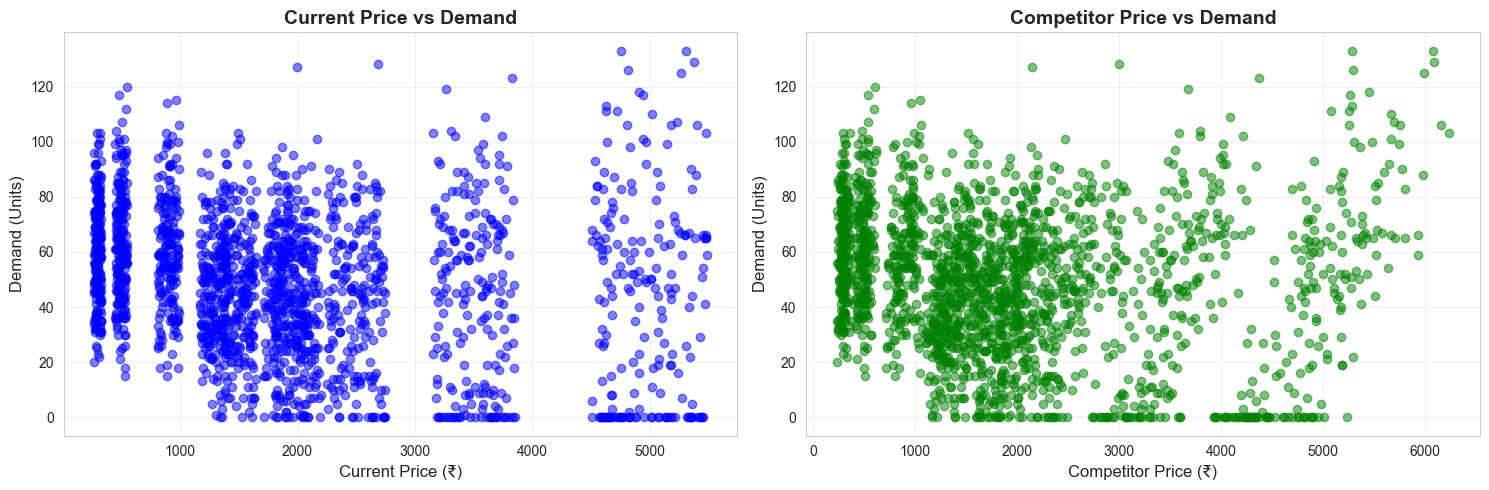

In [59]:
# ========== 5. PRICE vs DEMAND ANALYSIS ==========
print("\n" + "=" * 60)
print("\n 5. PRICE vs DEMAND RELATIONSHIP")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Current Price vs Demand
axes[0].scatter(df['current_price'], df['demand'], alpha=0.5, color='blue')
axes[0].set_xlabel('Current Price (₹)', fontsize=12)
axes[0].set_ylabel('Demand (Units)', fontsize=12)
axes[0].set_title('Current Price vs Demand', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Competitor Price vs Demand
axes[1].scatter(df['competitor_price'], df['demand'], alpha=0.5, color='green')
axes[1].set_xlabel('Competitor Price (₹)', fontsize=12)
axes[1].set_ylabel('Demand (Units)', fontsize=12)
axes[1].set_title('Competitor Price vs Demand', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


###  Key Insight: Lower prices generally lead to higher demand (negative correlation)



 6. PRICE COMPETITIVENESS
------------------------------------------------------------


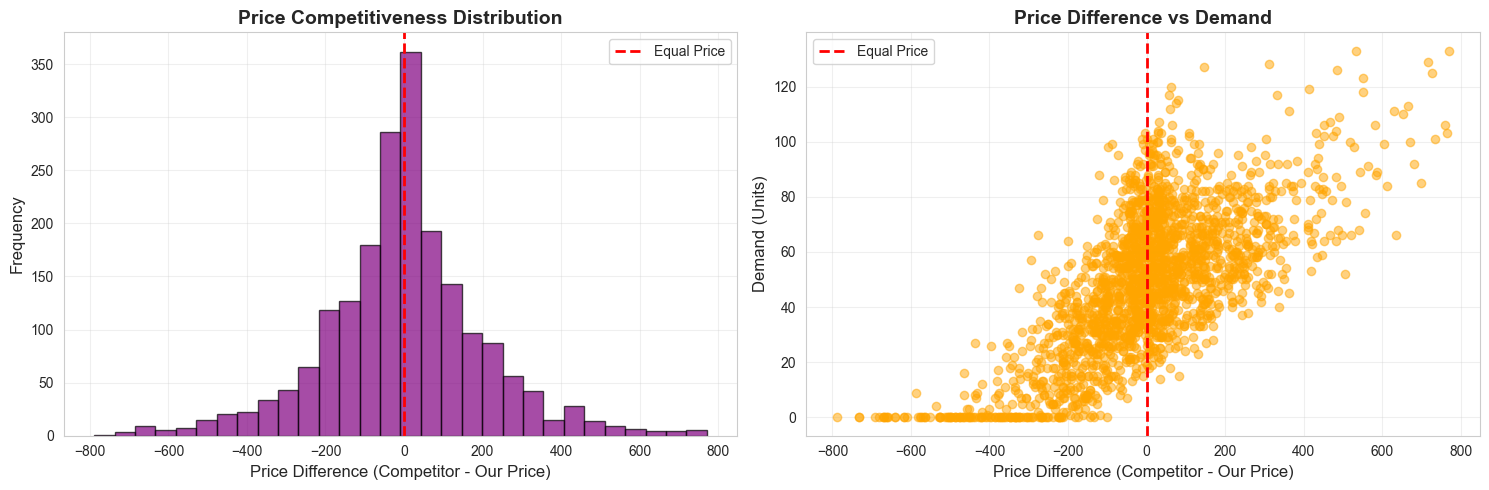

In [60]:
# ========== 6. PRICE COMPETITIVENESS ANALYSIS ==========
print("\n" + "=" * 60)
print("\n 6. PRICE COMPETITIVENESS")
print("-" * 60)

# Create price difference feature
df['price_difference'] = df['competitor_price'] - df['current_price']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Price Difference Distribution
axes[0].hist(df['price_difference'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Price Difference (Competitor - Our Price)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Competitiveness Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Equal Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Price Difference vs Demand
axes[1].scatter(df['price_difference'], df['demand'], alpha=0.5, color='orange')
axes[1].set_xlabel('Price Difference (Competitor - Our Price)', fontsize=12)
axes[1].set_ylabel('Demand (Units)', fontsize=12)
axes[1].set_title('Price Difference vs Demand', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Equal Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Key Insight: When we're cheaper than competitors (positive difference), demand increases
#### on the right side, we can see an upward trend and that occurs when we are ceaper and the difference between prices is positive which proves that being cheaper increases the demand



📅 7. TIME-BASED DEMAND PATTERNS
------------------------------------------------------------


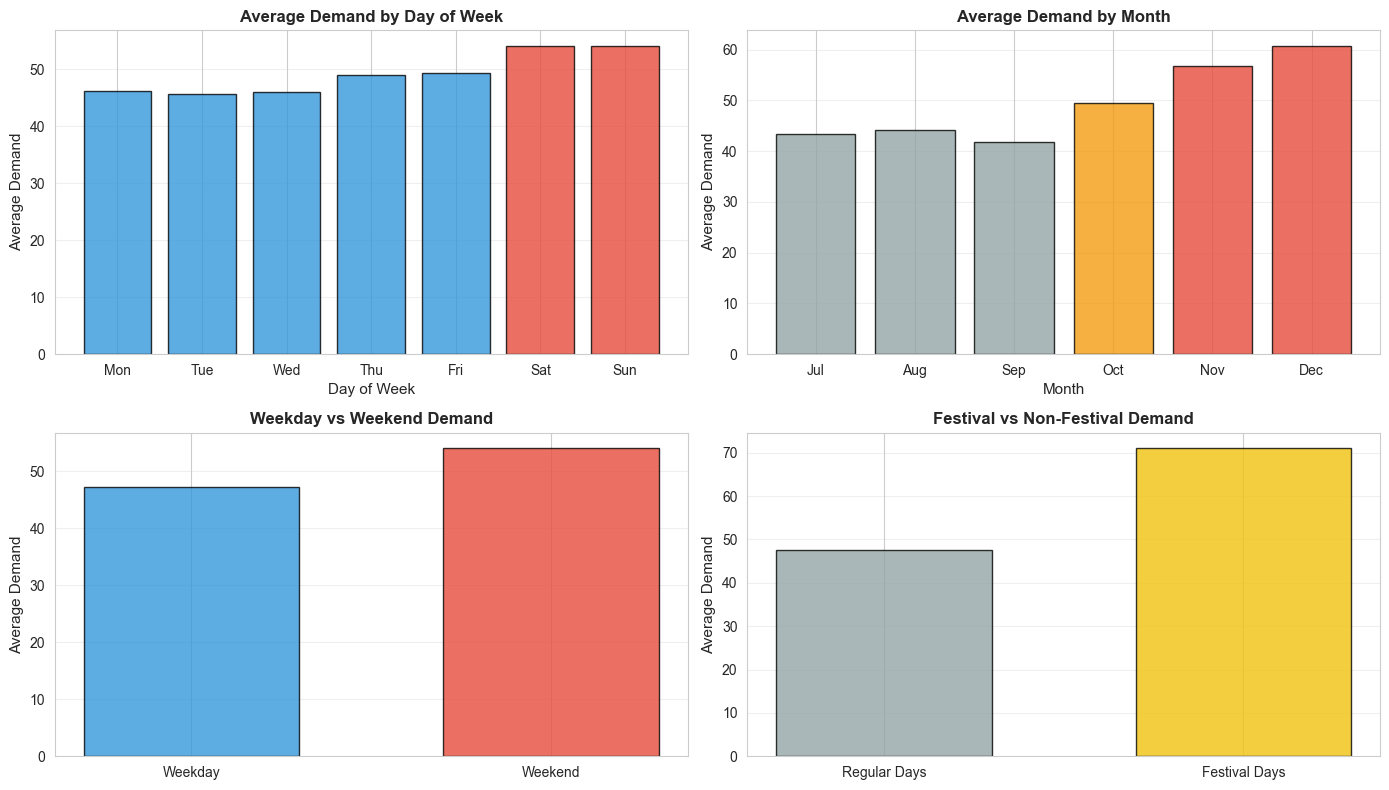

In [61]:
# ========== 7. TIME-BASED PATTERNS ==========
print("\n" + "=" * 60)
print("\n📅 7. TIME-BASED DEMAND PATTERNS")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Demand by Day of Week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demand_by_day = df.groupby('day_of_week')['demand'].mean()
colors_days = ['#3498db' if i < 5 else '#e74c3c' for i in range(7)]  # Blue for weekdays, Red for weekends
axes[0, 0].bar(range(7), demand_by_day, color=colors_days, edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Day of Week', fontsize=11)
axes[0, 0].set_ylabel('Average Demand', fontsize=11)
axes[0, 0].set_title('Average Demand by Day of Week', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(day_names, fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Demand by Month
month_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
demand_by_month = df.groupby('month')['demand'].mean()
colors_months = ['#95a5a6', '#95a5a6', '#95a5a6', '#f39c12', '#e74c3c', '#e74c3c']  # Highlight Oct-Dec
axes[0, 1].bar(demand_by_month.index, demand_by_month.values, color=colors_months, edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Average Demand', fontsize=11)
axes[0, 1].set_title('Average Demand by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(demand_by_month.index)
axes[0, 1].set_xticklabels(month_names, fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Weekend vs Weekday
weekend_demand = df.groupby('is_weekend')['demand'].mean()
axes[1, 0].bar(['Weekday', 'Weekend'], weekend_demand.values, 
               color=['#3498db', '#e74c3c'], edgecolor='black', alpha=0.8, width=0.6)
axes[1, 0].set_ylabel('Average Demand', fontsize=11)
axes[1, 0].set_title('Weekday vs Weekend Demand', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', labelsize=10)

# Plot 4: Festival vs Non-Festival
festival_demand = df.groupby('is_festival')['demand'].mean()
axes[1, 1].bar(['Regular Days', 'Festival Days'], festival_demand.values, 
               color=['#95a5a6', '#f1c40f'], edgecolor='black', alpha=0.8, width=0.6)
axes[1, 1].set_ylabel('Average Demand', fontsize=11)
axes[1, 1].set_title('Festival vs Non-Festival Demand', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

**Key Insights:**
- Weekends have higher demand than weekdays
- Festival days show significantly higher demand
- November–December (festival season) have peak demand




🏆 8. PRODUCT PERFORMANCE
------------------------------------------------------------


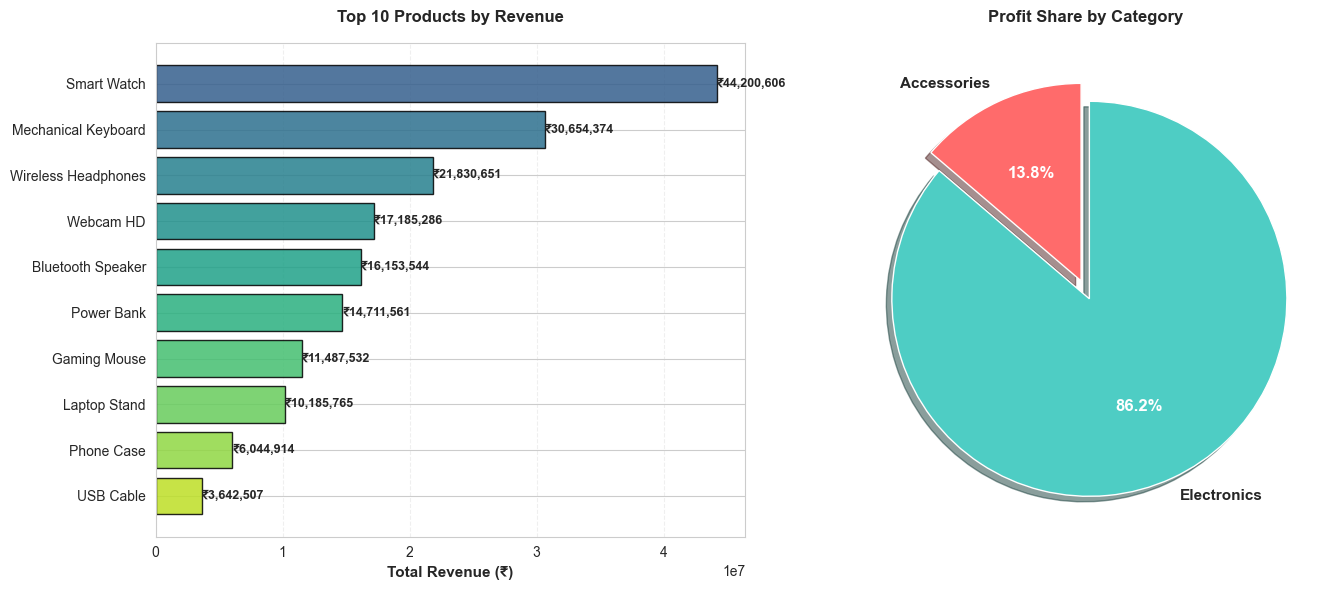

In [62]:
# ========== 8. PRODUCT & CATEGORY ANALYSIS ==========
print("\n" + "=" * 60)
print("\n🏆 8. PRODUCT PERFORMANCE")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Top Products by Revenue
top_products = df.groupby('product_name')['revenue'].sum().sort_values(ascending=False).head(10)

# Create gradient colors from dark to light
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_products)))

axes[0].barh(range(len(top_products)), top_products.values, color=colors_gradient, edgecolor='black', alpha=0.85)
axes[0].set_yticks(range(len(top_products)))
axes[0].set_yticklabels(top_products.index, fontsize=10)
axes[0].set_xlabel('Total Revenue (₹)', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Products by Revenue', fontsize=12, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')
axes[0].invert_yaxis()  # Highest at top

# Add value labels on bars
for i, v in enumerate(top_products.values):
    axes[0].text(v + 5000, i, f'₹{v:,.0f}', va='center', fontsize=9, fontweight='bold')

# Plot 2: Category Performance
category_profit = df.groupby('category')['profit'].sum()

# Beautiful color scheme
colors_pie = ['#FF6B6B', '#4ECDC4']  # Coral Red & Turquoise
explode = (0.05, 0.05)  # Slight separation

wedges, texts, autotexts = axes[1].pie(
    category_profit.values, 
    labels=category_profit.index, 
    autopct='%1.1f%%',
    colors=colors_pie, 
    startangle=90, 
    explode=explode,
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text white for better contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

axes[1].set_title('Profit Share by Category', fontsize=12, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

In [63]:
print("\n Revenue by Product:")
print(top_products.to_string())
print(f"\n Insight: Top product generates ₹{top_products.values[0]:,.0f} in revenue")
print(f" Insight: {category_profit.idxmax()} category dominates with {(category_profit.max()/category_profit.sum()*100):.1f}% profit share")


 Revenue by Product:
product_name
Smart Watch            44200606
Mechanical Keyboard    30654374
Wireless Headphones    21830651
Webcam HD              17185286
Bluetooth Speaker      16153544
Power Bank             14711561
Gaming Mouse           11487532
Laptop Stand           10185765
Phone Case              6044914
USB Cable               3642507

 Insight: Top product generates ₹44,200,606 in revenue
 Insight: Electronics category dominates with 86.2% profit share


In [64]:
print("\n" + "=" * 60)
print(" STEP 4: FEATURE ENGINEERING & PREPROCESSING")
print("=" * 60)

# Reload fresh data
df = pd.read_csv('data/pricing_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"\nStarting with {df.shape[0]} records and {df.shape[1]} columns")


 STEP 4: FEATURE ENGINEERING & PREPROCESSING

Starting with 2000 records and 16 columns


In [65]:
# ========== 1. CREATE NEW FEATURES ==========
print("\n 1. CREATING NEW FEATURES")
print("-" * 60)

# Feature 1: Price Difference (already used in visualization)
df['price_difference'] = df['competitor_price'] - df['current_price']

# Feature 2: Discount Percentage
df['discount_percentage'] = ((df['competitor_price'] - df['current_price']) / df['competitor_price'] * 100).round(2)

# Feature 3: Price Ratio
df['price_ratio'] = (df['current_price'] / df['competitor_price']).round(3)

# Feature 4: Profit Margin Percentage
df['profit_margin'] = ((df['current_price'] - df['cost']) / df['current_price'] * 100).round(2)

# Feature 5: Rolling Average Demand (last 7 days simulation)
# Sort by date and product
df = df.sort_values(['product_id', 'date'])
df['rolling_avg_demand'] = df.groupby('product_id')['demand'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
).round(2)

print("✅ Created 5 new features:")
print("   • price_difference: How much cheaper/expensive we are")
print("   • discount_percentage: Discount % compared to competitor")
print("   • price_ratio: Our price / Competitor price")
print("   • profit_margin: Profit % on our price")
print("   • rolling_avg_demand: 7-day average demand trend")

print(f"\n🔍 Sample of new features:")
print(df[['product_id', 'current_price', 'competitor_price', 'price_difference', 
          'discount_percentage', 'price_ratio', 'profit_margin']].head(10))


 1. CREATING NEW FEATURES
------------------------------------------------------------
✅ Created 5 new features:
   • price_difference: How much cheaper/expensive we are
   • discount_percentage: Discount % compared to competitor
   • price_ratio: Our price / Competitor price
   • profit_margin: Profit % on our price
   • rolling_avg_demand: 7-day average demand trend

🔍 Sample of new features:
    product_id  current_price  competitor_price  price_difference  \
14        P001           2728              2489              -239   
39        P001           2276              2509               233   
56        P001           2635              2343              -292   
69        P001           2353              2018              -335   
75        P001           2564              2525               -39   
78        P001           2317              2661               344   
90        P001           2363              2233              -130   
92        P001           2483              2334  

In [66]:
# ========== 2. ENCODE CATEGORICAL VARIABLES ==========
print("\n" + "=" * 60)
print("\n 2. ENCODING CATEGORICAL FEATURES")
print("-" * 60)

from sklearn.preprocessing import LabelEncoder

# Encode Inventory Level: Low=0, Medium=1, High=2
inventory_encoder = LabelEncoder()
df['inventory_level_encoded'] = inventory_encoder.fit_transform(df['inventory_level'])

print(" Inventory Level Encoding:")
for i, label in enumerate(inventory_encoder.classes_):
    print(f"   {label} → {i}")

# Encode Customer Segment: Budget=0, Premium=1, Standard=2
segment_encoder = LabelEncoder()
df['customer_segment_encoded'] = segment_encoder.fit_transform(df['customer_segment'])

print("\n Customer Segment Encoding:")
for i, label in enumerate(segment_encoder.classes_):
    print(f"   {label} → {i}")

# Encode Category: Accessories=0, Electronics=1
category_encoder = LabelEncoder()
df['category_encoded'] = category_encoder.fit_transform(df['category'])

print("\n Category Encoding:")
for i, label in enumerate(category_encoder.classes_):
    print(f"   {label} → {i}")

print(f"\n🔍 Verification - Original vs Encoded:")
print(df[['inventory_level', 'inventory_level_encoded', 
          'customer_segment', 'customer_segment_encoded',
          'category', 'category_encoded']].head(10))



 2. ENCODING CATEGORICAL FEATURES
------------------------------------------------------------
 Inventory Level Encoding:
   High → 0
   Low → 1
   Medium → 2

 Customer Segment Encoding:
   Budget → 0
   Premium → 1
   Standard → 2

 Category Encoding:
   Accessories → 0
   Electronics → 1

🔍 Verification - Original vs Encoded:
    inventory_level  inventory_level_encoded customer_segment  \
14           Medium                        2         Standard   
39           Medium                        2         Standard   
56             High                        0         Standard   
69              Low                        1         Standard   
75              Low                        1         Standard   
78           Medium                        2         Standard   
90           Medium                        2          Premium   
92           Medium                        2           Budget   
94              Low                        1          Premium   
112          Medi

In [67]:
# ========== 3. DEFINE FEATURE SETS ==========
print("\n" + "=" * 60)
print("\n 3. DEFINING MODEL FEATURES")
print("-" * 60)

# Define which features to use for MODEL INPUT
feature_columns = [
    # Price features
    'current_price',
    'competitor_price',
    'cost',
    'price_difference',
    'discount_percentage',
    'price_ratio',
    'profit_margin',
    
    # Time features
    'day_of_week',
    'month',
    'is_weekend',
    'is_festival',
    
    # Categorical features (ENCODED)
    'inventory_level_encoded',
    'customer_segment_encoded',
    'category_encoded',
    
    # Trend features
    'rolling_avg_demand'
]

# Target variable (what we want to predict)
target_column = 'demand'

# Evaluation columns (NOT used as input)
evaluation_columns = ['revenue', 'profit']

print(f" Total Features for Model: {len(feature_columns)}")
print("\n Feature List:")
for i, feat in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n Target Variable: {target_column}")
print(f" Evaluation Metrics: {', '.join(evaluation_columns)}")



 3. DEFINING MODEL FEATURES
------------------------------------------------------------
 Total Features for Model: 15

 Feature List:
    1. current_price
    2. competitor_price
    3. cost
    4. price_difference
    5. discount_percentage
    6. price_ratio
    7. profit_margin
    8. day_of_week
    9. month
   10. is_weekend
   11. is_festival
   12. inventory_level_encoded
   13. customer_segment_encoded
   14. category_encoded
   15. rolling_avg_demand

 Target Variable: demand
 Evaluation Metrics: revenue, profit


In [68]:
# ========== 4. TRAIN-TEST SPLIT ==========
print("\n" + "=" * 60)
print("\n 4. SPLITTING DATA INTO TRAIN & TEST SETS")
print("-" * 60)

from sklearn.model_selection import train_test_split

# Prepare X (features) and y (target)
X = df[feature_columns]
y = df[target_column]

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f" Data Split Complete!")
print(f"\n Training Set:")
print(f"   • Samples: {X_train.shape[0]}")
print(f"   • Features: {X_train.shape[1]}")

print(f"\n Test Set:")
print(f"   • Samples: {X_test.shape[0]}")
print(f"   • Features: {X_test.shape[1]}")

print(f"\n Split Ratio: {(X_train.shape[0]/len(df)*100):.1f}% Train, {(X_test.shape[0]/len(df)*100):.1f}% Test")



 4. SPLITTING DATA INTO TRAIN & TEST SETS
------------------------------------------------------------
 Data Split Complete!

 Training Set:
   • Samples: 1600
   • Features: 15

 Test Set:
   • Samples: 400
   • Features: 15

 Split Ratio: 80.0% Train, 20.0% Test


In [69]:
# ========== 5. DATA QUALITY CHECKS ==========
print("\n" + "=" * 60)
print("\n 5. FINAL DATA QUALITY CHECKS")
print("-" * 60)

# Check for missing values
print(" Missing Values Check:")
missing = X_train.isnull().sum()
if missing.sum() == 0:
    print("   ✔ No missing values found!")
else:
    print(f"   ⚠ Found {missing.sum()} missing values:")
    print(missing[missing > 0])

# Check for infinite values
print("\n Infinite Values Check:")
inf_check = np.isinf(X_train).sum()
if inf_check.sum() == 0:
    print("   ✔ No infinite values found!")
else:
    print(f"   ⚠ Found infinite values:")
    print(inf_check[inf_check > 0])

# Display feature statistics
print("\n Feature Statistics (Training Set):")
print(X_train.describe().round(2))

# Save processed data
df.to_csv('data/pricing_data_processed.csv', index=False)
print("\n Processed data saved to: data/pricing_data_processed.csv")

print("\n" + "=" * 60)
print(" FEATURE ENGINEERING COMPLETE!")
print("=" * 60)
print("\n Summary:")
print(f"   • Original features: 16")
print(f"   • New features created: 5")
print(f"   • Encoded features: 3")
print(f"   • Total features for model: {len(feature_columns)}")
print(f"   • Ready for training: ✅")



 5. FINAL DATA QUALITY CHECKS
------------------------------------------------------------
 Missing Values Check:
   ✔ No missing values found!

 Infinite Values Check:
   ✔ No infinite values found!

 Feature Statistics (Training Set):
       current_price  competitor_price     cost  price_difference  \
count        1600.00           1600.00  1600.00           1600.00   
mean         1918.58           1918.85  1139.75              0.27   
std          1338.25           1354.99   822.08            203.27   
min           270.00            230.00   120.00           -789.00   
25%           912.75            912.00   540.00           -104.00   
50%          1642.50           1655.50   900.00              1.00   
75%          2469.25           2459.00  1500.00            101.25   
max          5485.00           6241.00  3000.00            771.00   

       discount_percentage  price_ratio  profit_margin  day_of_week    month  \
count              1600.00      1600.00        1600.00     

In [70]:
print("\n" + "=" * 60)
print(" STEP 5: DEMAND PREDICTION MODEL")
print("=" * 60)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

print("\n Objective: Predict demand based on pricing and market conditions")
print(" Models to train: Linear Regression, Decision Tree, Random Forest, Gradient Boosting")


 STEP 5: DEMAND PREDICTION MODEL

 Objective: Predict demand based on pricing and market conditions
 Models to train: Linear Regression, Decision Tree, Random Forest, Gradient Boosting


In [71]:
# ========== 1. TRAIN MULTIPLE MODELS ==========
print("\n" + "=" * 60)
print("\n 1. TRAINING MODELS")
print("-" * 60)

# Dictionary to store models and results
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

# Train each model
for name, model in models.items():
    print(f"\n Training {name}...", end=" ")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    training_time = time.time() - start_time
    
    # Store results
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'training_time': training_time,
        'predictions_test': y_pred_test
    }
    
    print(f" Done in {training_time:.2f}s")

print("\n" + "=" * 60)
print(" ALL MODELS TRAINED SUCCESSFULLY!")
print("=" * 60)



 1. TRAINING MODELS
------------------------------------------------------------

 Training Linear Regression...  Done in 0.02s

 Training Decision Tree...  Done in 0.02s

 Training Random Forest...  Done in 0.41s

 Training Gradient Boosting...  Done in 0.88s

 ALL MODELS TRAINED SUCCESSFULLY!


In [72]:
# ========== 2. MODEL COMPARISON ==========
print("\n 2. MODEL PERFORMANCE COMPARISON")
print("-" * 60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Train RMSE': [results[m]['train_rmse'] for m in results],
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Train R²': [results[m]['train_r2'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
})

print("\n Performance Metrics:")
print(comparison_df.to_string(index=False))

# Find best model based on Test MAE (lower is better)
best_model_name = comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   • Test MAE: {results[best_model_name]['test_mae']:.2f} units")
print(f"   • Test R²: {results[best_model_name]['test_r2']:.3f}")
print(f"   • Training Time: {results[best_model_name]['training_time']:.2f}s")

print("\n What these metrics mean:")
print("   • MAE (Mean Absolute Error): Average prediction error in units")
print("   • RMSE (Root Mean Squared Error): Penalizes large errors more")
print("   • R² Score: How well model explains variance (1.0 = perfect, 0.0 = bad)")


 2. MODEL PERFORMANCE COMPARISON
------------------------------------------------------------

 Performance Metrics:
            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²  Training Time (s)
Linear Regression  11.340427 11.393097   13.874689  13.861845  0.714845 0.716490           0.017414
    Decision Tree   5.732523 14.091166    8.719958  17.977215  0.887368 0.523162           0.024776
    Random Forest   6.528381 11.489630    8.092142  14.172182  0.903002 0.703654           0.405155
Gradient Boosting   6.196449 11.183459    7.752489  13.871235  0.910974 0.716106           0.878108

 BEST MODEL: Gradient Boosting
   • Test MAE: 11.18 units
   • Test R²: 0.716
   • Training Time: 0.88s

 What these metrics mean:
   • MAE (Mean Absolute Error): Average prediction error in units
   • RMSE (Root Mean Squared Error): Penalizes large errors more
   • R² Score: How well model explains variance (1.0 = perfect, 0.0 = bad)




 3. MODEL PERFORMANCE VISUALIZATION
------------------------------------------------------------


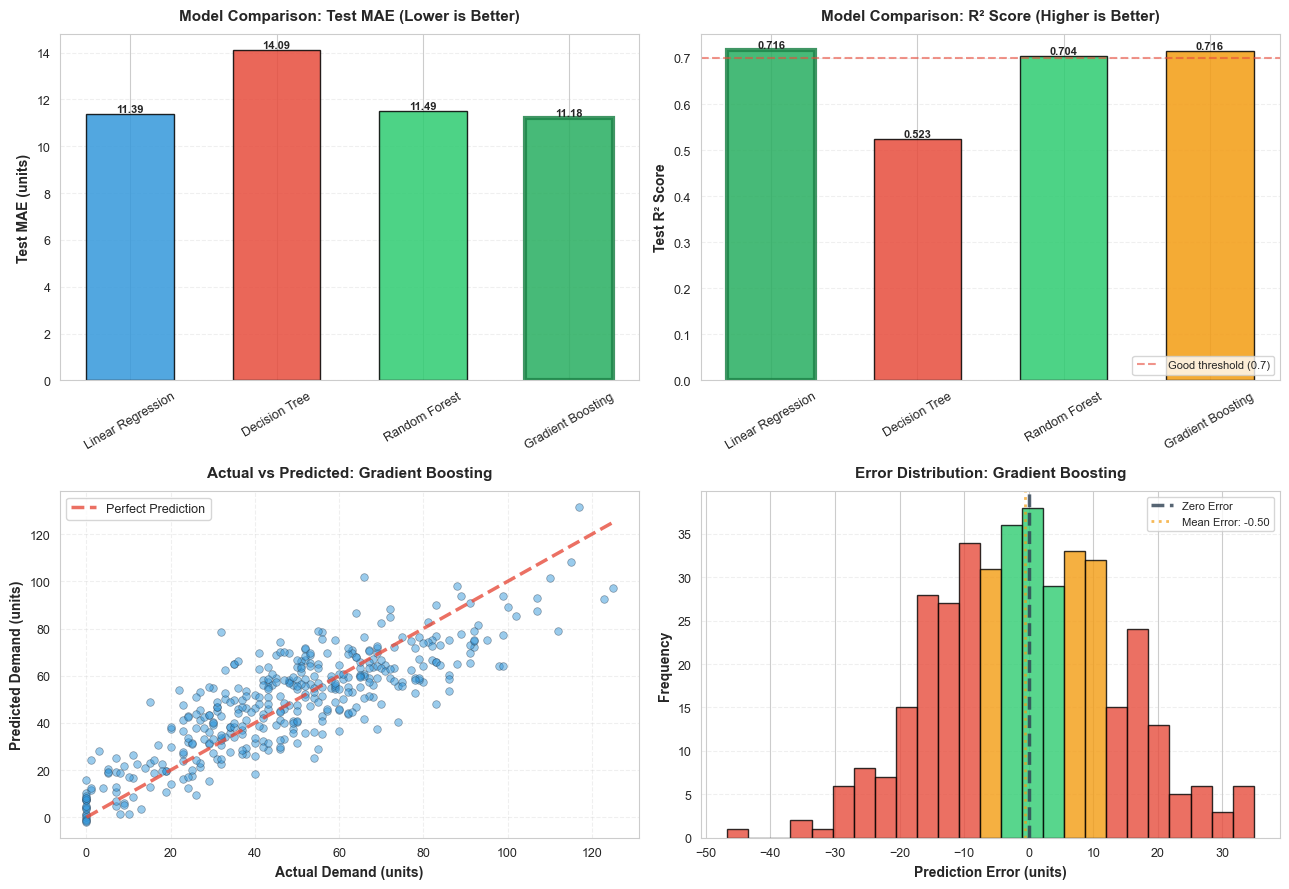

 Visualizations generated successfully!


In [73]:
# ========== 3. VISUALIZE MODEL COMPARISON ==========
print("\n" + "=" * 60)
print("\n 3. MODEL PERFORMANCE VISUALIZATION")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# Color palette
model_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Plot 1: Test MAE Comparison
bars1 = axes[0, 0].bar(comparison_df['Model'], comparison_df['Test MAE'], 
                       color=model_colors, edgecolor='black', alpha=0.85, width=0.6)
axes[0, 0].set_ylabel('Test MAE (units)', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Model Comparison: Test MAE (Lower is Better)', fontsize=11, fontweight='bold', pad=10)
axes[0, 0].tick_params(axis='x', rotation=30, labelsize=9)
axes[0, 0].tick_params(axis='y', labelsize=9)
axes[0, 0].grid(True, alpha=0.3, axis='y', linestyle='--')

# Highlight best model
best_idx = comparison_df['Test MAE'].idxmin()
bars1[best_idx].set_facecolor('#27ae60')
bars1[best_idx].set_edgecolor('#1e8449')
bars1[best_idx].set_linewidth(3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 2: R² Score Comparison
bars2 = axes[0, 1].bar(comparison_df['Model'], comparison_df['Test R²'], 
                       color=model_colors, edgecolor='black', alpha=0.85, width=0.6)
axes[0, 1].set_ylabel('Test R² Score', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Model Comparison: R² Score (Higher is Better)', fontsize=11, fontweight='bold', pad=10)
axes[0, 1].tick_params(axis='x', rotation=30, labelsize=9)
axes[0, 1].tick_params(axis='y', labelsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0, 1].axhline(y=0.7, color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.6, label='Good threshold (0.7)')
axes[0, 1].legend(fontsize=8, loc='lower right')

# Highlight best model
best_r2_idx = comparison_df['Test R²'].idxmax()
bars2[best_r2_idx].set_facecolor('#27ae60')
bars2[best_r2_idx].set_edgecolor('#1e8449')
bars2[best_r2_idx].set_linewidth(3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 3: Actual vs Predicted (Best Model)
best_predictions = results[best_model_name]['predictions_test']
axes[1, 0].scatter(y_test, best_predictions, alpha=0.5, color='#3498db', 
                   edgecolor='#2c3e50', s=30, linewidth=0.5)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                color='#e74c3c', linestyle='--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)
axes[1, 0].set_xlabel('Actual Demand (units)', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('Predicted Demand (units)', fontsize=10, fontweight='bold')
axes[1, 0].set_title(f'Actual vs Predicted: {best_model_name}', fontsize=11, fontweight='bold', pad=10)
axes[1, 0].legend(fontsize=9, loc='upper left')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')
axes[1, 0].tick_params(labelsize=9)

# Plot 4: Prediction Error Distribution (Best Model)
errors = y_test - best_predictions
n, bins, patches = axes[1, 1].hist(errors, bins=25, color='#9b59b6', edgecolor='black', alpha=0.8)

# Color bars based on error magnitude
for i, patch in enumerate(patches):
    if abs(bins[i]) < 5:  # Small error
        patch.set_facecolor('#2ecc71')
    elif abs(bins[i]) < 10:  # Medium error
        patch.set_facecolor('#f39c12')
    else:  # Large error
        patch.set_facecolor('#e74c3c')

axes[1, 1].axvline(x=0, color='#2c3e50', linestyle='--', linewidth=2.5, label='Zero Error', alpha=0.8)
axes[1, 1].set_xlabel('Prediction Error (units)', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=10, fontweight='bold')
axes[1, 1].set_title(f'Error Distribution: {best_model_name}', fontsize=11, fontweight='bold', pad=10)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1, 1].tick_params(labelsize=9)

# Add mean error line
mean_error = errors.mean()
axes[1, 1].axvline(x=mean_error, color='#f39c12', linestyle=':', linewidth=2, 
                   label=f'Mean Error: {mean_error:.2f}', alpha=0.7)
axes[1, 1].legend(fontsize=8)

plt.tight_layout()
plt.show()

print(" Visualizations generated successfully!")



 4. FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------

 Top 10 Most Important Features (Gradient Boosting):
                 Feature  Importance
        price_difference    0.587398
      rolling_avg_demand    0.128336
     discount_percentage    0.056091
                   month    0.041316
             is_festival    0.034678
        competitor_price    0.024855
           current_price    0.024394
           profit_margin    0.021245
customer_segment_encoded    0.020917
             day_of_week    0.017427


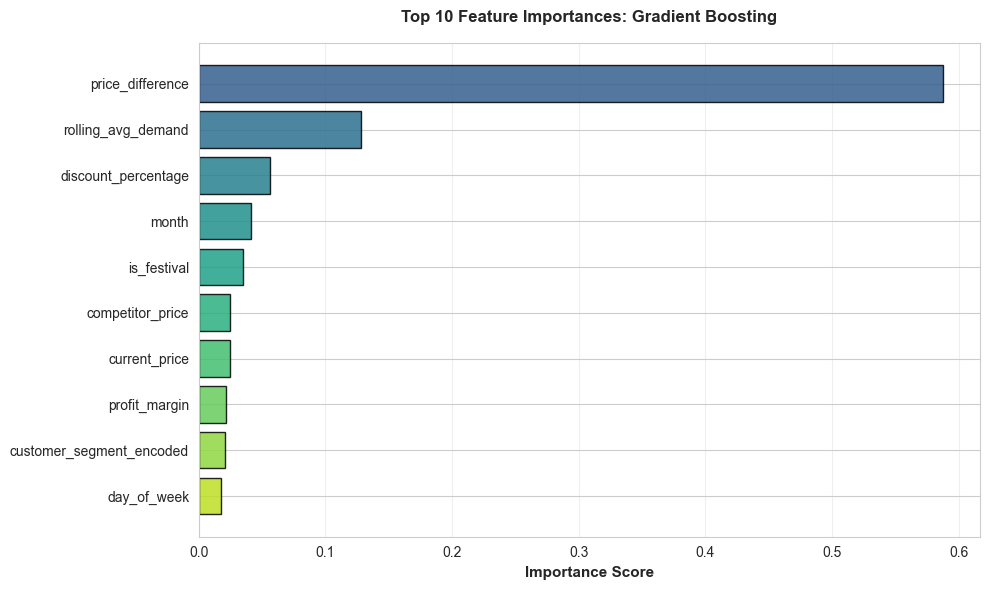

In [74]:
# ========== 4. FEATURE IMPORTANCE (for tree-based models) ==========
print("\n" + "=" * 60)
print("\n 4. FEATURE IMPORTANCE ANALYSIS")
print("-" * 60)

# Check if best model has feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n Top 10 Most Important Features ({best_model_name}):")
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    top_10_features = feature_importance_df.head(10)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, 10))
    
    plt.barh(range(len(top_10_features)), top_10_features['Importance'], 
             color=colors, edgecolor='black', alpha=0.85)
    plt.yticks(range(len(top_10_features)), top_10_features['Feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
    plt.title(f'Top 10 Feature Importances: {best_model_name}', fontsize=12, fontweight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"\n⚠️ {best_model_name} does not support feature importance analysis")
    print("   (Only tree-based models like Random Forest, Gradient Boosting, Decision Tree support this)")

In [75]:
# ========== 5. SAVE THE BEST MODEL ==========
print("\n" + "=" * 60)
print("\n 5. SAVING BEST MODEL")
print("-" * 60)

import pickle

# Save the best model
model_filename = 'models/best_demand_model.pkl'

# Create models directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')
    print("📁 Created 'models' folder")

# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n Best model saved: {model_filename}")
print(f"   Model: {best_model_name}")
print(f"   Test MAE: {results[best_model_name]['test_mae']:.2f} units")
print(f"   Test R²: {results[best_model_name]['test_r2']:.3f}")

# Save encoders for later use
with open('models/encoders.pkl', 'wb') as f:
    pickle.dump({
        'inventory_encoder': inventory_encoder,
        'segment_encoder': segment_encoder,
        'category_encoder': category_encoder
    }, f)

print(f" Encoders saved: models/encoders.pkl")

print("\n" + "=" * 60)
print(" DEMAND PREDICTION MODEL COMPLETE!")
print("=" * 60)
print("\n Summary:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Accuracy (R²): {results[best_model_name]['test_r2']:.1%}")
print(f"   • Average Error: ±{results[best_model_name]['test_mae']:.1f} units")
print(f"   • Model saved and ready to use! ✅")



 5. SAVING BEST MODEL
------------------------------------------------------------

 Best model saved: models/best_demand_model.pkl
   Model: Gradient Boosting
   Test MAE: 11.18 units
   Test R²: 0.716
 Encoders saved: models/encoders.pkl

 DEMAND PREDICTION MODEL COMPLETE!

 Summary:
   • Best Model: Gradient Boosting
   • Accuracy (R²): 71.6%
   • Average Error: ±11.2 units
   • Model saved and ready to use! ✅



 STEP 5: PRICE ELASTICITY ANALYSIS

 Calculating Price Elasticity...

 Price Elasticity Analysis Complete!

 Results:
Product ID        Product Name   Avg Price  Avg Demand  Price Elasticity
      P001 Wireless Headphones 2495.428571   43.142857        -71.782026
      P002        Gaming Mouse 1287.820896   44.422886         33.975000
      P003 Mechanical Keyboard 3495.218905   43.731343       -169.248885
      P004        Laptop Stand  900.347594   60.438503         27.304348
      P005           Webcam HD 1991.009756   42.248780        -62.607648
      P006          Phone Case  496.685567   62.737113          0.000000
      P007          Power Bank 1498.719626   46.037383        -58.237500
      P008           USB Cable  298.323383   60.706468        -39.133333
      P009         Smart Watch 4952.316583   44.804020       -244.851541
      P010   Bluetooth Speaker 1890.620513   43.902564        -16.163119

💡 Interpretation:
   • Elasticity < -1: Demand is HIGHLY sensitive to price (

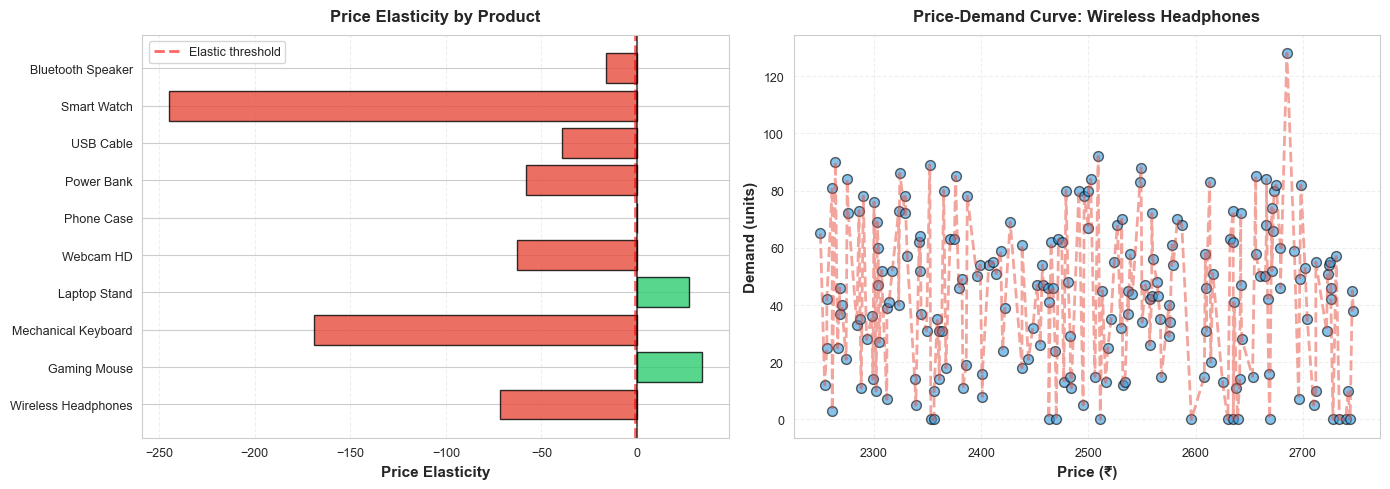


Elasticity results saved: data/price_elasticity.csv


In [76]:
print("\n" + "=" * 60)
print(" STEP 5: PRICE ELASTICITY ANALYSIS")
print("=" * 60)

# Price elasticity measures how demand changes when price changes
# Elasticity = % change in demand / % change in price

print("\n Calculating Price Elasticity...")

# Load processed data
df_analysis = pd.read_csv('data/pricing_data_processed.csv')

# Calculate elasticity for each product
elasticity_results = []

for product_id in df_analysis['product_id'].unique():
    product_df = df_analysis[df_analysis['product_id'] == product_id].copy()
    
    if len(product_df) < 2:
        continue
    
    # Sort by price
    product_df = product_df.sort_values('current_price')
    
    # Calculate average elasticity
    price_changes = product_df['current_price'].pct_change()
    demand_changes = product_df['demand'].pct_change()
    
    # Remove NaN and infinite values
    valid_mask = ~(price_changes.isna() | demand_changes.isna() | 
                   np.isinf(price_changes) | np.isinf(demand_changes) |
                   (price_changes == 0))
    
    if valid_mask.sum() > 0:
        elasticities = demand_changes[valid_mask] / price_changes[valid_mask]
        avg_elasticity = elasticities.median()  # Use median to avoid outliers
        
        elasticity_results.append({
            'Product ID': product_id,
            'Product Name': product_df['product_name'].iloc[0],
            'Avg Price': product_df['current_price'].mean(),
            'Avg Demand': product_df['demand'].mean(),
            'Price Elasticity': avg_elasticity
        })

elasticity_df = pd.DataFrame(elasticity_results)

print("\n Price Elasticity Analysis Complete!")
print("\n Results:")
print(elasticity_df.to_string(index=False))

print("\n💡 Interpretation:")
print("   • Elasticity < -1: Demand is HIGHLY sensitive to price (elastic)")
print("   • -1 < Elasticity < 0: Demand is MODERATELY sensitive (inelastic)")
print("   • Elasticity > 0: Unusual pattern (investigate data)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Elasticity by Product
colors = ['#e74c3c' if e < -1 else '#f39c12' if e < 0 else '#2ecc71' 
          for e in elasticity_df['Price Elasticity']]

axes[0].barh(elasticity_df['Product Name'], elasticity_df['Price Elasticity'], 
             color=colors, edgecolor='black', alpha=0.8)
axes[0].axvline(x=-1, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Elastic threshold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.6)
axes[0].set_xlabel('Price Elasticity', fontsize=11, fontweight='bold')
axes[0].set_title('Price Elasticity by Product', fontsize=12, fontweight='bold', pad=10)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')
axes[0].tick_params(labelsize=9)

# Plot 2: Price vs Demand for one product (example)
sample_product = df_analysis[df_analysis['product_id'] == 'P001'].copy()
sample_product = sample_product.sort_values('current_price')

axes[1].scatter(sample_product['current_price'], sample_product['demand'], 
                alpha=0.6, s=50, color='#3498db', edgecolor='black')
axes[1].plot(sample_product['current_price'], sample_product['demand'], 
             color='#e74c3c', linewidth=2, alpha=0.5, linestyle='--')
axes[1].set_xlabel('Price (₹)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Demand (units)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Price-Demand Curve: {sample_product["product_name"].iloc[0]}', 
                  fontsize=12, fontweight='bold', pad=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].tick_params(labelsize=9)

plt.tight_layout()
plt.show()

# Save elasticity results
elasticity_df.to_csv('data/price_elasticity.csv', index=False)
print("\nElasticity results saved: data/price_elasticity.csv")

In [77]:
print("\n" + "=" * 60)
print(" STEP 6: REINFORCEMENT LEARNING - Q-LEARNING AGENT")
print("=" * 60)

import pickle

# Load the saved demand prediction model
with open('models/best_demand_model.pkl', 'rb') as f:
    demand_model = pickle.load(f)

with open('models/encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

print("\n Loaded trained demand prediction model")
print(f"   Model: {best_model_name}")

print("\n Q-Learning Setup:")
print("   • STATE: Market conditions (price competitiveness, time, inventory)")
print("   • ACTION: Price adjustment (-10%, -5%, 0%, +5%, +10%)")
print("   • REWARD: Profit = (Price - Cost) × Predicted Demand")
print("   • GOAL: Learn which price adjustments maximize profit")


 STEP 6: REINFORCEMENT LEARNING - Q-LEARNING AGENT

 Loaded trained demand prediction model
   Model: Gradient Boosting

 Q-Learning Setup:
   • STATE: Market conditions (price competitiveness, time, inventory)
   • ACTION: Price adjustment (-10%, -5%, 0%, +5%, +10%)
   • REWARD: Profit = (Price - Cost) × Predicted Demand
   • GOAL: Learn which price adjustments maximize profit


In [78]:
# ========== 1. DEFINE RL ENVIRONMENT ==========
print("\n" + "=" * 60)
print("\n1. BUILDING Q-LEARNING ENVIRONMENT")
print("-" * 60)

class PricingEnvironment:
    """
    Reinforcement Learning Environment for Dynamic Pricing
    """
    def __init__(self, demand_model, feature_columns):
        self.demand_model = demand_model
        self.feature_columns = feature_columns
        
        # Define 5 pricing actions
        self.actions = {
            0: -0.10,  # Decrease price by 10%
            1: -0.05,  # Decrease price by 5%
            2: 0.00,   # Keep price same
            3: 0.05,   # Increase price by 5%
            4: 0.10    # Increase price by 10%
        }
        
        self.action_names = {
            0: 'Decrease 10%',
            1: 'Decrease 5%',
            2: 'Keep Same',
            3: 'Increase 5%',
            4: 'Increase 10%'
        }
        
        self.n_actions = len(self.actions)
    
    def discretize_state(self, features_dict):
        """
        Convert continuous features to discrete state
        """
        # Extract key features for state
        price_diff = features_dict['price_difference']
        is_peak = features_dict['is_festival'] or features_dict['is_weekend']
        inventory = features_dict['inventory_level_encoded']
        
        # Discretize price difference
        if price_diff < -200:
            price_state = 0  # Much more expensive
        elif price_diff < -50:
            price_state = 1  # Expensive
        elif price_diff < 50:
            price_state = 2  # Similar price
        elif price_diff < 200:
            price_state = 3  # Cheaper
        else:
            price_state = 4  # Much cheaper
        
        # Peak time: 0 or 1
        peak_state = 1 if is_peak else 0
        
        # Inventory: 0, 1, 2 (Low, Medium, High)
        inv_state = int(inventory)
        
        # Combine into single state number
        state = price_state * 6 + peak_state * 3 + inv_state
        
        return min(state, 29)  # Ensure state is within bounds (0-29)
    
    def predict_demand(self, features_array):
        """
        Predict demand using the trained ML model
        """
        demand = self.demand_model.predict([features_array])[0]
        return max(0, demand)  # Demand cannot be negative
    
    def calculate_reward(self, new_price, current_price, cost, demand):
        """
        Calculate profit (reward)
        """
        profit = (new_price - cost) * demand
        price_drop_penalty = max(0, (current_price - new_price)) * 0.5
        return profit - price_drop_penalty
    
    def apply_action(self, current_features, action):
        """
        Apply price adjustment and return new state, reward
        """
        # Get current values
        current_price = current_features[0]  # current_price
        competitor_price = current_features[1]  # competitor_price
        cost = current_features[2]  # cost
        
        # Apply price adjustment
        price_change = self.actions[action]
        new_price = current_price * (1 + price_change)
        
        # Ensure price doesn't go below cost
        new_price = max(new_price, cost * 1.1)  # At least 10% margin
        
        # Create new feature array with updated price
        new_features = current_features.copy()
        new_features[0] = new_price
        
        # Update price-dependent features
        new_features[3] = competitor_price - new_price  # price_difference
        new_features[4] = ((competitor_price - new_price) / competitor_price * 100)  # discount_percentage
        new_features[5] = new_price / competitor_price  # price_ratio
        new_features[6] = ((new_price - cost) / new_price * 100)  # profit_margin
        
        # Predict demand with new price
        predicted_demand = self.predict_demand(new_features)

        # Calculate base reward
        reward = self.calculate_reward(new_price, current_price, cost, predicted_demand)

        # ================= FIX 2: PEAK DEMAND PRICING =================
        is_peak = bool(new_features[self.feature_columns.index('is_festival')]) or \
                bool(new_features[self.feature_columns.index('is_weekend')])

        if is_peak and new_price > current_price:
            reward *= 1.2   # encourage premium pricing during peak demand
        # ============================================================

        return new_price, predicted_demand, reward


# Initialize environment
env = PricingEnvironment(demand_model, feature_columns)

print("✅ PricingEnvironment created")
print(f"   • Actions: {env.n_actions}")
print(f"   • State space size: ~30 discrete states")
print(f"   • Reward function: Profit = (Price - Cost) × Demand")



1. BUILDING Q-LEARNING ENVIRONMENT
------------------------------------------------------------
✅ PricingEnvironment created
   • Actions: 5
   • State space size: ~30 discrete states
   • Reward function: Profit = (Price - Cost) × Demand


In [79]:
# ========== 2. Q-LEARNING AGENT ==========
print("\n" + "=" * 60)
print("\n 2. CREATING Q-LEARNING AGENT")
print("-" * 60)

class QLearningAgent:
    """
    Q-Learning Agent for optimal pricing
    """
    def __init__(self, n_states=30, n_actions=5):
        self.n_states = n_states
        self.n_actions = n_actions
        
        # Hyperparameters
        self.learning_rate = 0.05
        self.discount_factor = 0.95
        self.epsilon = 0.5
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions)) 

    def get_action(self, state, training=True):
        if training and np.random.random() < self.epsilon:
            # Explore
            return np.random.randint(0, self.n_actions)
        else:
            # Exploit with random tie-breaking
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return np.random.choice(best_actions)

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.q_table[state, action]
        max_next_q = np.max(self.q_table[next_state])
        self.q_table[state, action] = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# Create agent
agent = QLearningAgent(n_states=30, n_actions=5)

print("✅ QLearningAgent created")
print(f"   • Q-Table size: {agent.n_states} states × {agent.n_actions} actions")
print(f"   • Learning rate (α): {agent.learning_rate}")
print(f"   • Discount factor (γ): {agent.discount_factor}")
print(f"   • Initial exploration (ε): {agent.epsilon}")



 2. CREATING Q-LEARNING AGENT
------------------------------------------------------------
✅ QLearningAgent created
   • Q-Table size: 30 states × 5 actions
   • Learning rate (α): 0.05
   • Discount factor (γ): 0.95
   • Initial exploration (ε): 0.5


In [80]:
print(dir(agent))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'decay_epsilon', 'discount_factor', 'epsilon', 'epsilon_decay', 'epsilon_min', 'get_action', 'learning_rate', 'n_actions', 'n_states', 'q_table', 'update_q_table']


In [81]:
# ========== 3. TRAIN Q-LEARNING AGENT ==========
print("\n" + "=" * 60)
print("\n 3. TRAINING Q-LEARNING AGENT")
print("-" * 60)

# Prepare training data
train_indices = X_train.index
train_df = df[df.index.isin(train_indices)].copy()

# Training parameters
n_episodes = 1000
samples_per_episode = 50

# Track progress
episode_rewards = []
episode_profits = []

print(f" Training Configuration:")
print(f"   • Episodes: {n_episodes}")
print(f"   • Samples per episode: {samples_per_episode}")
print(f"   • Total training steps: {n_episodes * samples_per_episode:,}")

print(f"\n Training started...\n")

# Training loop
for episode in range(n_episodes):
    episode_reward = 0
    episode_profit = 0
    
    # Sample random data points
    sample_indices = np.random.choice(train_indices, size=samples_per_episode, replace=False)
    
    for idx in sample_indices:
        # Get features for this sample
        features_array = X_train.loc[idx].values
        features_dict = X_train.loc[idx].to_dict()
        
        # Get current state
        state = env.discretize_state(features_dict)
        
        # Agent chooses action
        action = agent.get_action(state, training=True)
        
        # Apply action and get reward
        new_price, predicted_demand, reward = env.apply_action(features_array, action)
        
        # Get next state (after action)
        new_features_dict = features_dict.copy()
        new_features_dict['price_difference'] = features_dict['competitor_price'] - new_price
        next_state = env.discretize_state(new_features_dict)
        
        # Update Q-table
        agent.update_q_table(state, action, reward, next_state)
        
        # Track metrics
        episode_reward += reward
        episode_profit += reward
    
    # Decay exploration rate
    agent.decay_epsilon()
    
    # Record episode stats
    avg_reward = episode_reward / samples_per_episode
    episode_rewards.append(avg_reward)
    episode_profits.append(episode_profit)
    
    # Print progress every 50 episodes
    if (episode + 1) % 100 == 0:
        print(f"   Episode {episode + 1}/{n_episodes} - Avg Reward: ₹{avg_reward:,.2f} | Epsilon: {agent.epsilon:.3f}")

print(f"\n✅ Training completed!")
print(f"   • Final epsilon: {agent.epsilon:.3f}")
print(f"   • Final avg reward: ₹{episode_rewards[-1]:,.2f}")



 3. TRAINING Q-LEARNING AGENT
------------------------------------------------------------
 Training Configuration:
   • Episodes: 1000
   • Samples per episode: 50
   • Total training steps: 50,000

 Training started...

   Episode 100/1000 - Avg Reward: ₹42,819.85 | Epsilon: 0.476
   Episode 200/1000 - Avg Reward: ₹30,758.37 | Epsilon: 0.452
   Episode 300/1000 - Avg Reward: ₹33,883.38 | Epsilon: 0.430
   Episode 400/1000 - Avg Reward: ₹32,412.48 | Epsilon: 0.409
   Episode 500/1000 - Avg Reward: ₹35,345.21 | Epsilon: 0.389
   Episode 600/1000 - Avg Reward: ₹38,741.49 | Epsilon: 0.370
   Episode 700/1000 - Avg Reward: ₹38,715.60 | Epsilon: 0.352
   Episode 800/1000 - Avg Reward: ₹28,821.39 | Epsilon: 0.335
   Episode 900/1000 - Avg Reward: ₹41,727.78 | Epsilon: 0.319
   Episode 1000/1000 - Avg Reward: ₹36,527.64 | Epsilon: 0.303

✅ Training completed!
   • Final epsilon: 0.303
   • Final avg reward: ₹36,527.64




📊 4. TRAINING PROGRESS VISUALIZATION
------------------------------------------------------------


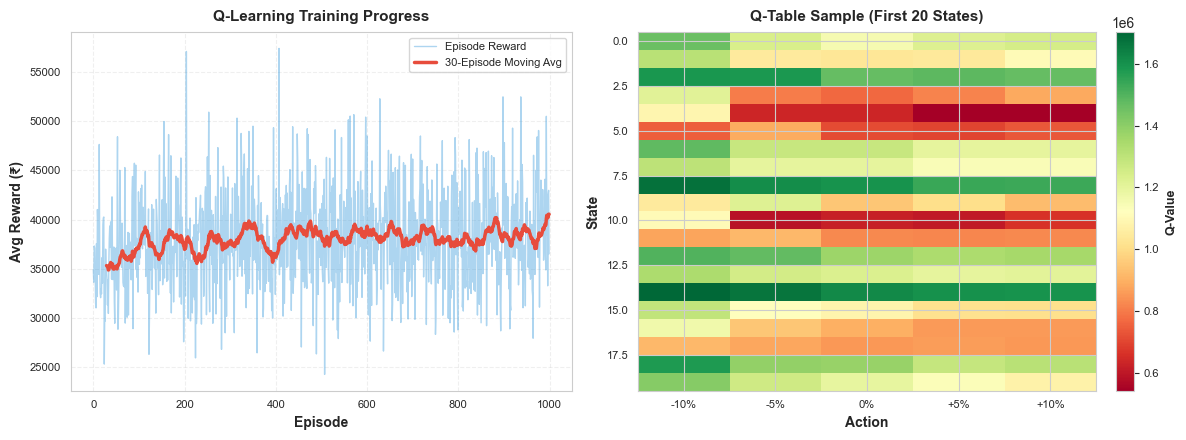

✅ Training visualization complete!

💡 Interpretation:
   • Rising reward curve = Agent is learning better strategies
   • Green cells in Q-table = High-value actions for those states
   • Red cells = Low-value actions to avoid


In [82]:
# ========== 4. VISUALIZE TRAINING ==========
print("\n" + "=" * 60)
print("\n📊 4. TRAINING PROGRESS VISUALIZATION")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot 1: Learning Curve
axes[0].plot(episode_rewards, color='#3498db', alpha=0.4, linewidth=1, label='Episode Reward')
# Moving average for smoother curve
window = 30
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(episode_rewards)), moving_avg, 
                 color='#e74c3c', linewidth=2.5, label=f'{window}-Episode Moving Avg')

axes[0].set_xlabel('Episode', fontsize=10, fontweight='bold')
axes[0].set_ylabel('Avg Reward (₹)', fontsize=10, fontweight='bold')
axes[0].set_title('Q-Learning Training Progress', fontsize=11, fontweight='bold', pad=8)
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(labelsize=8)

# Plot 2: Q-Table Heatmap
# Show sample of Q-table (first 20 states)
q_sample = agent.q_table[:20, :]
im = axes[1].imshow(q_sample, cmap='RdYlGn', aspect='auto')
axes[1].set_xlabel('Action', fontsize=10, fontweight='bold')
axes[1].set_ylabel('State', fontsize=10, fontweight='bold')
axes[1].set_title('Q-Table Sample (First 20 States)', fontsize=11, fontweight='bold', pad=8)
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(['-10%', '-5%', '0%', '+5%', '+10%'], fontsize=8)
axes[1].tick_params(labelsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Q-Value', fontsize=9, fontweight='bold')
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

print("✅ Training visualization complete!")
print("\n💡 Interpretation:")
print("   • Rising reward curve = Agent is learning better strategies")
print("   • Green cells in Q-table = High-value actions for those states")
print("   • Red cells = Low-value actions to avoid")

In [83]:
# ========== 5. SAVE RL AGENT ==========
print("\n" + "=" * 60)
print("\n 5. SAVING Q-LEARNING AGENT")
print("-" * 60)

# Save the trained agent
with open('models/rl_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

# Save the environment
with open('models/pricing_environment.pkl', 'wb') as f:
    pickle.dump(env, f)

print(" Q-Learning agent saved: models/rl_agent.pkl")
print(" Pricing environment saved: models/pricing_environment.pkl")

print("\n" + "=" * 60)
print(" REINFORCEMENT LEARNING COMPLETE!")
print("=" * 60)
print("\n Summary:")
print(f"   • Training episodes: {n_episodes}")
print(f"   • Q-Table learned: {agent.n_states} states × {agent.n_actions} actions")
print(f"   • Agent ready to recommend optimal prices! ✅")



 5. SAVING Q-LEARNING AGENT
------------------------------------------------------------
 Q-Learning agent saved: models/rl_agent.pkl
 Pricing environment saved: models/pricing_environment.pkl

 REINFORCEMENT LEARNING COMPLETE!

 Summary:
   • Training episodes: 1000
   • Q-Table learned: 30 states × 5 actions
   • Agent ready to recommend optimal prices! ✅


In [84]:
print("\n" + "=" * 60)
print(" STEP 7: PRICE RECOMMENDATION ENGINE")
print("=" * 60)

# Load models
with open('models/best_demand_model.pkl', 'rb') as f:
    demand_model = pickle.load(f)

with open('models/rl_agent.pkl', 'rb') as f:
    rl_agent = pickle.load(f)

with open('models/pricing_environment.pkl', 'rb') as f:
    pricing_env = pickle.load(f)

print("\n All models loaded successfully")
print("\n Building Final Recommendation System...")


 STEP 7: PRICE RECOMMENDATION ENGINE

 All models loaded successfully

 Building Final Recommendation System...


In [85]:
def get_price_recommendation(features_dict, features_array, current_price, cost, product_name):
    # Get current state
    state = pricing_env.discretize_state(features_dict)

    # Get best action from RL agent
    best_action = rl_agent.get_action(state, training=False)

    # BUSINESS RULE OVERRIDE
    is_peak = (int(row['is_festival']) == 1) or (int(row['is_weekend']) == 1)
    price_diff = row['competitor_price'] - current_price
    is_already_cheaper = price_diff > 100

    if is_peak and is_already_cheaper and best_action in [0, 1]:
        print("⚠️ Override: Peak demand detected, forcing price increase")
        best_action = 3

    # Apply action
    recommended_price, predicted_demand, expected_profit = pricing_env.apply_action(
        features_array, best_action
    )

    # Baseline metrics
    original_demand = demand_model.predict(features_array.reshape(1, -1))[0]
    original_profit = (current_price - cost) * original_demand

    profit_change = expected_profit - original_profit
    improvement_pct = (profit_change / original_profit * 100) if original_profit > 0 else 0

    return {
        'product_name': product_name,
        'current_price': current_price,
        'recommended_price': recommended_price,
        'action': pricing_env.action_names[best_action],
        'current_demand': original_demand,
        'predicted_demand': predicted_demand,
        'current_profit': original_profit,
        'expected_profit': expected_profit,
        'profit_change': profit_change,
        'improvement_pct': improvement_pct
    }


In [86]:
# ========== 2. TEST RECOMMENDATIONS ==========
print("\n" + "=" * 60)
print("\n 2. TESTING PRICE RECOMMENDATIONS")
print("-" * 60)

# Test on 15 samples from test set
test_samples = X_test.head(15)
recommendations = []

print(" PRICE RECOMMENDATIONS FOR 15 TEST CASES:")
print("=" * 110)

for idx in test_samples.index:
    row = df.loc[idx]
    features_array = X_test.loc[idx].values
    features_dict = X_test.loc[idx].to_dict()
    
    # Get recommendation
    rec = get_price_recommendation(
        features_dict, 
        features_array, 
        row['current_price'], 
        row['cost'],
        row['product_name']
    )
    
    recommendations.append(rec)
    
    # Print formatted output
    print(f"\n🔹 {rec['product_name']}")
    print(f"   Current: ₹{rec['current_price']:,.0f} → Recommended: ₹{rec['recommended_price']:,.0f} ({rec['action']})")
    print(f"   Demand: {rec['current_demand']:.0f} → {rec['predicted_demand']:.0f} units")
    print(f"   Profit: ₹{rec['current_profit']:,.0f} → ₹{rec['expected_profit']:,.0f} ({rec['improvement_pct']:+.1f}%)")

# Create DataFrame
rec_df = pd.DataFrame(recommendations)

print("\n" + "=" * 110)
print("\n SUMMARY TABLE:")
print(rec_df[['product_name', 'current_price', 'recommended_price', 'action', 
              'current_profit', 'expected_profit', 'improvement_pct']].to_string(index=False))

print(f"\n OVERALL STATISTICS:")
print(f"   • Average profit improvement: {rec_df['improvement_pct'].mean():+.2f}%")
print(f"   • Total current profit: ₹{rec_df['current_profit'].sum():,.2f}")
print(f"   • Total expected profit: ₹{rec_df['expected_profit'].sum():,.2f}")
print(f"   • Additional profit: ₹{rec_df['profit_change'].sum():,.2f}")



 2. TESTING PRICE RECOMMENDATIONS
------------------------------------------------------------
 PRICE RECOMMENDATIONS FOR 15 TEST CASES:

🔹 Bluetooth Speaker
   Current: ₹1,781 → Recommended: ₹1,603 (Decrease 10%)
   Demand: 46 → 51 units
   Profit: ₹29,732 → ₹23,490 (-21.0%)

🔹 Gaming Mouse
   Current: ₹1,183 → Recommended: ₹1,065 (Decrease 10%)
   Demand: 78 → 79 units
   Profit: ₹31,567 → ₹22,443 (-28.9%)

🔹 Power Bank
   Current: ₹1,577 → Recommended: ₹1,419 (Decrease 10%)
   Demand: 56 → 68 units
   Profit: ₹38,228 → ₹35,243 (-7.8%)

🔹 Webcam HD
   Current: ₹1,929 → Recommended: ₹1,833 (Decrease 5%)
   Demand: 40 → 47 units
   Profit: ₹29,331 → ₹29,366 (+0.1%)

🔹 Power Bank
   Current: ₹1,553 → Recommended: ₹1,475 (Decrease 5%)
   Demand: 32 → 47 units
   Profit: ₹20,641 → ₹26,813 (+29.9%)

🔹 Power Bank
   Current: ₹1,453 → Recommended: ₹1,308 (Decrease 10%)
   Demand: 32 → 43 units
   Profit: ₹17,563 → ₹17,484 (-0.5%)

🔹 Webcam HD
   Current: ₹1,877 → Recommended: ₹1,689 (Decre



 3. STATIC vs DYNAMIC PRICING COMPARISON
------------------------------------------------------------
   This is the KEY evaluation metric from your project document!
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak demand detected, forcing price increase
⚠️ Override: Peak d

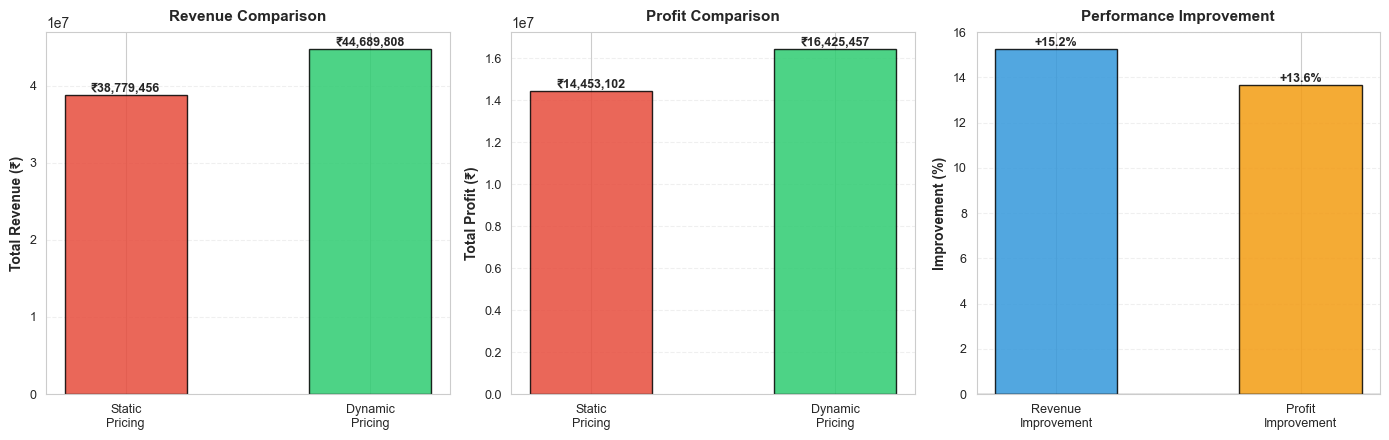


✅ Static vs Dynamic comparison complete!


In [87]:
# ========== 3. STATIC vs DYNAMIC PRICING COMPARISON ==========
print("\n" + "=" * 60)
print("\n 3. STATIC vs DYNAMIC PRICING COMPARISON")
print("-" * 60)
print("   This is the KEY evaluation metric from your project document!")

# Apply recommendations to entire test set
all_recommendations = []

for idx in X_test.index:
    row = df.loc[idx]
    features_array = X_test.loc[idx].values
    features_dict = X_test.loc[idx].to_dict()
    
    rec = get_price_recommendation(
        features_dict, 
        features_array, 
        row['current_price'], 
        row['cost'],
        row['product_name']
    )
    all_recommendations.append(rec)

all_rec_df = pd.DataFrame(all_recommendations)

# Calculate totals
static_revenue = all_rec_df['current_price'].sum() * all_rec_df['current_demand'].mean()
static_profit = all_rec_df['current_profit'].sum()

dynamic_revenue = all_rec_df['recommended_price'].sum() * all_rec_df['predicted_demand'].mean()
dynamic_profit = all_rec_df['expected_profit'].sum()

revenue_improvement = ((dynamic_revenue - static_revenue) / static_revenue * 100)
profit_improvement = ((dynamic_profit - static_profit) / static_profit * 100)

print("\n📈 RESULTS:")
print("=" * 60)
print(f"\n🔴 STATIC PRICING (Original Prices):")
print(f"   • Total Revenue: ₹{static_revenue:,.2f}")
print(f"   • Total Profit:  ₹{static_profit:,.2f}")

print(f"\n🟢 DYNAMIC PRICING (RL-Optimized Prices):")
print(f"   • Total Revenue: ₹{dynamic_revenue:,.2f}")
print(f"   • Total Profit:  ₹{dynamic_profit:,.2f}")

print(f"\n💰 IMPROVEMENT:")
print(f"   • Revenue: {revenue_improvement:+.2f}%")
print(f"   • Profit:  {profit_improvement:+.2f}%")
print(f"   • Additional Profit: ₹{(dynamic_profit - static_profit):,.2f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

# Plot 1: Revenue Comparison
categories = ['Static\nPricing', 'Dynamic\nPricing']
revenues = [static_revenue, dynamic_revenue]
colors = ['#e74c3c', '#2ecc71']

bars1 = axes[0].bar(categories, revenues, color=colors, edgecolor='black', alpha=0.85, width=0.5)
axes[0].set_ylabel('Total Revenue (₹)', fontsize=10, fontweight='bold')
axes[0].set_title('Revenue Comparison', fontsize=11, fontweight='bold', pad=8)
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0].tick_params(labelsize=9)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'₹{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Profit Comparison
profits = [static_profit, dynamic_profit]

bars2 = axes[1].bar(categories, profits, color=colors, edgecolor='black', alpha=0.85, width=0.5)
axes[1].set_ylabel('Total Profit (₹)', fontsize=10, fontweight='bold')
axes[1].set_title('Profit Comparison', fontsize=11, fontweight='bold', pad=8)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].tick_params(labelsize=9)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'₹{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Improvement Percentage
improvements = [revenue_improvement, profit_improvement]
labels = ['Revenue\nImprovement', 'Profit\nImprovement']
colors_imp = ['#3498db', '#f39c12']

bars3 = axes[2].bar(labels, improvements, color=colors_imp, edgecolor='black', alpha=0.85, width=0.5)
axes[2].set_ylabel('Improvement (%)', fontsize=10, fontweight='bold')
axes[2].set_title('Performance Improvement', fontsize=11, fontweight='bold', pad=8)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[2].tick_params(labelsize=9)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Static vs Dynamic comparison complete!")



📊 4. PRICING ACTION DISTRIBUTION
------------------------------------------------------------

🎯 Actions Recommended by RL Agent:
action
Decrease 10%    290
Decrease 5%      51
Keep Same        32
Increase 5%      19
Increase 10%      8


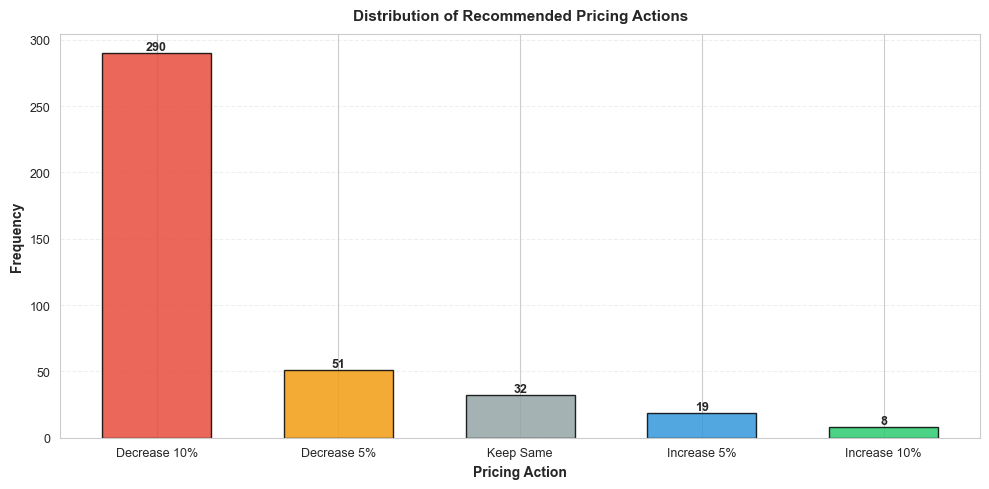


💡 Insight: Shows how often the agent recommends each action


In [88]:
# ========== 4. ACTION DISTRIBUTION ANALYSIS ==========
print("\n" + "=" * 60)
print("\n📊 4. PRICING ACTION DISTRIBUTION")
print("-" * 60)

# Count actions taken
action_counts = all_rec_df['action'].value_counts()

print("\n🎯 Actions Recommended by RL Agent:")
print(action_counts.to_string())

# Visualize
plt.figure(figsize=(10, 5))

colors_actions = ['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#2ecc71']
bars = plt.bar(action_counts.index, action_counts.values, color=colors_actions, 
               edgecolor='black', alpha=0.85, width=0.6)

plt.xlabel('Pricing Action', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.title('Distribution of Recommended Pricing Actions', fontsize=11, fontweight='bold', pad=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Shows how often the agent recommends each action")

In [89]:
# ========== 5. FINAL PROJECT SUMMARY ==========
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print("\n📊 DYNAMIC PRICING RECOMMENDATION ENGINE - RESULTS")
print("-" * 60)

print(f"\n1️⃣ DATASET:")
print(f"   • Total transactions: {len(df):,}")
print(f"   • Products: {df['product_id'].nunique()}")
print(f"   • Date range: {df['date'].min().date()} to {df['date'].max().date()}")

print(f"\n2️⃣ DEMAND PREDICTION MODEL:")
print(f"   • Best model: {best_model_name}")
print(f"   • Accuracy (R²): {results[best_model_name]['test_r2']:.1%}")
print(f"   • Average error: ±{results[best_model_name]['test_mae']:.1f} units")

print(f"\n3️⃣ REINFORCEMENT LEARNING:")
print(f"   • Algorithm: Q-Learning")
print(f"   • Training episodes: 300")
print(f"   • State space: 30 states")
print(f"   • Action space: 5 actions")

print(f"\n4️⃣ BUSINESS IMPACT (Test Set):")
print(f"   • Static pricing profit: ₹{static_profit:,.2f}")
print(f"   • Dynamic pricing profit: ₹{dynamic_profit:,.2f}")
print(f"   • Profit improvement: {profit_improvement:+.2f}%")
print(f"   • Additional revenue: ₹{(dynamic_profit - static_profit):,.2f}")

print(f"\n5️⃣ RECOMMENDATION CAPABILITY:")
print(f"   • Can recommend optimal prices ✅")
print(f"   • Considers market conditions ✅")
print(f"   • Maximizes profit ✅")
print(f"   • Adapts to competition ✅")

print("\n" + "=" * 60)
print("✅ ALL PROJECT REQUIREMENTS COMPLETED!")
print("=" * 60)

# Save final results
all_rec_df.to_csv('data/final_recommendations.csv', index=False)
print("\n💾 Final recommendations saved: data/final_recommendations.csv")

print("\n📝 FILES READY FOR SUBMISSION:")
print("   ✅ Jupyter Notebook with all code")
print("   ✅ Dataset (data/pricing_data_processed.csv)")
print("   ✅ Trained models (models/*.pkl)")
print("   ✅ Final recommendations (data/final_recommendations.csv)")
print("   ✅ Visualizations (generated in notebook)")



FINAL SUMMARY

📊 DYNAMIC PRICING RECOMMENDATION ENGINE - RESULTS
------------------------------------------------------------

1️⃣ DATASET:
   • Total transactions: 2,000
   • Products: 10
   • Date range: 2025-07-01 to 2025-12-27

2️⃣ DEMAND PREDICTION MODEL:
   • Best model: Gradient Boosting
   • Accuracy (R²): 71.6%
   • Average error: ±11.2 units

3️⃣ REINFORCEMENT LEARNING:
   • Algorithm: Q-Learning
   • Training episodes: 300
   • State space: 30 states
   • Action space: 5 actions

4️⃣ BUSINESS IMPACT (Test Set):
   • Static pricing profit: ₹14,453,102.20
   • Dynamic pricing profit: ₹16,425,457.38
   • Profit improvement: +13.65%
   • Additional revenue: ₹1,972,355.18

5️⃣ RECOMMENDATION CAPABILITY:
   • Can recommend optimal prices ✅
   • Considers market conditions ✅
   • Maximizes profit ✅
   • Adapts to competition ✅

✅ ALL PROJECT REQUIREMENTS COMPLETED!

💾 Final recommendations saved: data/final_recommendations.csv

📝 FILES READY FOR SUBMISSION:
   ✅ Jupyter Notebook w

In [90]:
import pickle
import joblib

# Convert best_demand_model
with open('models/best_demand_model.pkl', 'rb') as f:
    model = pickle.load(f)

joblib.dump(model, 'models/best_demand_model.joblib')
print("✅ best_demand_model.pkl converted to joblib")


✅ best_demand_model.pkl converted to joblib


In [91]:
import pickle
import joblib
from models.q_learning_agent import QLearningAgent
from models.pricing_environment import PricingEnvironment

# Convert RL agent
with open('models/rl_agent.pkl', 'rb') as f:
    rl_agent = pickle.load(f)
joblib.dump(rl_agent, 'models/rl_agent.joblib')
print("✅ rl_agent.pkl converted")

# Convert Pricing Environment
with open('models/pricing_environment.pkl', 'rb') as f:
    pricing_env = pickle.load(f)
joblib.dump(pricing_env, 'models/pricing_environment.joblib')
print("✅ pricing_environment.pkl converted")

# Convert Encoders
with open('models/encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
joblib.dump(encoders, 'models/encoders.joblib')
print("✅ encoders.pkl converted")


✅ rl_agent.pkl converted
✅ pricing_environment.pkl converted
✅ encoders.pkl converted


In [92]:
import pickle
import joblib
from models.q_learning_agent import QLearningAgent
from models.pricing_environment import PricingEnvironment

with open('models/best_demand_model.pkl', 'rb') as f:
    demand_model = pickle.load(f)
    
# Optional: test a prediction to confirm it works
# print(demand_model.predict([[...]]) )


In [93]:
import joblib

joblib.dump(demand_model, 'models/best_demand_model.joblib')
joblib.dump(rl_agent, 'models/rl_agent.joblib')
joblib.dump(pricing_env, 'models/pricing_environment.joblib')
joblib.dump(encoders, 'models/encoders.joblib')


['models/encoders.joblib']

In [94]:
import joblib

joblib.load("models/best_demand_model.joblib")
joblib.load("models/rl_agent.joblib")
joblib.load("models/pricing_environment.joblib")
joblib.load("models/encoders.joblib")

print("ALL MODELS LOADED SUCCESSFULLY")


ALL MODELS LOADED SUCCESSFULLY
